In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b 
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.9827,  0.4160]) 
label: tensor([0.8110])


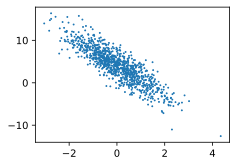

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3182,  0.0281],
        [ 0.6742,  1.1984],
        [ 0.8262, -1.1810],
        [-1.0146,  1.4034],
        [ 0.4570, -0.7054],
        [-0.4258, -0.5148],
        [ 0.4437,  1.3465],
        [ 0.5519, -0.2123],
        [-0.4439, -0.7223],
        [-0.0556,  0.3248]]) 
 tensor([[ 3.4607],
        [ 1.4801],
        [ 9.8563],
        [-2.5837],
        [ 7.5044],
        [ 5.0965],
        [ 0.5079],
        [ 6.0320],
        [ 5.7695],
        [ 2.9861]])


In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) 
b = torch.zeros(1, requires_grad=True)

In [7]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [8]:
def squared_loss(y_hat, y): #@save
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [9]:
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的⼩批量损失
    # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
    # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037306
epoch 2, loss 0.000142
epoch 3, loss 0.000048


In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0006, 0.0007], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


⼩结   
• 我们学习了深度⽹络是如何实现和优化的。在这⼀过程中只使⽤张量和⾃动微分，不需要定义层或复杂的优化器。   
• 这⼀节只触及到了表⾯知识。在下⾯的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

练习
1. 如果我们将权重初始化为零，会发⽣什么。算法仍然有效吗？
2. 假设你是乔治·西蒙·欧姆，试图为电压和电流的关系建⽴⼀个模型。你能使⽤⾃动微分来学习模型的参数吗?
3. 您能基于普朗克定律使⽤光谱能量密度来确定物体的温度吗？
4. 如果你想计算⼆阶导数可能会遇到什么问题？你会如何解决这些问题？
5. 为什么在squared_loss函数中需要使⽤reshape函数？
6. 尝试使⽤不同的学习率，观察损失函数值下降的快慢。
7. 如果样本个数不能被批量⼤小整除，data_iter函数的⾏为会有什么变化？

1. 在单层网络中(一层线性回归层)，将权重初始化为零时可以的，但是网络层数加深后，在全连接的情况下，在反向传播的时候，由 于权重的对称性会导致出现隐藏神经元的对称性，使得多个隐藏神经元的作用就如同1个神经元，算法还是有效的，但是效果不大好。参考：    
https://zhuanlan.zhihu.com/p/75879624


2. 可以的，建立模型U=IW+b，然后采集(U，I)的数据集，通过自动微分即可学习W和b的参数。

3. 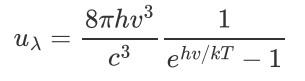

In [9]:
4.
#二阶导数的正向计算图无法直接获得，可以通过保存一阶导数的计算图使得可以求二阶导数(create_graph和retain_graph都置 为True，
#保存原函数和一阶导数的正向计算图)。实验如下：
import torch

x = torch.randn((2), requires_grad=True) 
y = x**3
dy = torch.autograd.grad(y, x, grad_outputs=torch.ones(x.shape),
                         retain_graph=True, create_graph=True)
dy2 = torch.autograd.grad(dy, x, grad_outputs=torch.ones(x.shape))
dy_ = 3*x**2
dy2_ = 6*x
print("======================================================")
print(dy, dy_)
print("======================================================")
print(dy2, dy2_)

(tensor([0.2210, 0.8270], grad_fn=<MulBackward0>),) tensor([0.2210, 0.8270], grad_fn=<MulBackward0>)
(tensor([-1.6285, -3.1502]),) tensor([-1.6285, -3.1502], grad_fn=<MulBackward0>)


关于create_graph和retain_graph的参考：https://zhuanlan.zhihu.com/p/84890656

5. 以防y^和y，一个是行向量、一个是列向量，使用reshape，可以确保shape一样。

6. ①学习率过大前期下降很快，但是后面不容易收敛； ②学习率过小损失函数下降会很慢。

7. 报错。